In [5]:
import sys,os
sys.modules["mpi4py"] = None

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
	
from lenstools import dataExtern
from lenstools.statistics.ensemble import Series,Ensemble
from lenstools.statistics.constraints import Emulator
from lenstools.statistics.contours import ContourPlot

### Unpickle the emulator, data and covariance matrix

In [6]:
emulator = Emulator.read(os.path.join(dataExtern(),"sample","emulator.pkl"))
test_data = pd.read_pickle(os.path.join(dataExtern(),"sample","data.pkl"))
covariance = Ensemble.read(os.path.join(dataExtern(),"sample","covariance.pkl"))

### Map the likelihood in the $(\Omega_m,\sigma_8)$ plane

In [7]:
p = Ensemble.meshgrid({"Om":np.linspace(0.2,0.5,50),"sigma8":np.linspace(0.6,0.9,50)})
p["w"] = -1.
scores = emulator.score(p,test_data,features_covariance=covariance,correct=1000)
scores["likelihood"] = np.exp(-0.5*scores[emulator.feature_names[0]])

### Approximate the emulator linearly around the maximum (Fisher matrix)

In [8]:
fisher = emulator.approximate_linear(center=(0.26,-1.,0.8))

#Consider (OmegaM,sigma8) only
fisher.pop(("parameters","w"))
fisher = fisher.iloc[[0,1,3]]

### MCMC sampling of $(\Omega_m,\sigma_8)$

In [11]:
samples = emulator.sample_posterior(test_data,features_covariance=covariance,correct=1000,pslice={"w":-1},sample="emcee")[emulator.feature_names[0]]

### Plot

(0.6, 0.9)

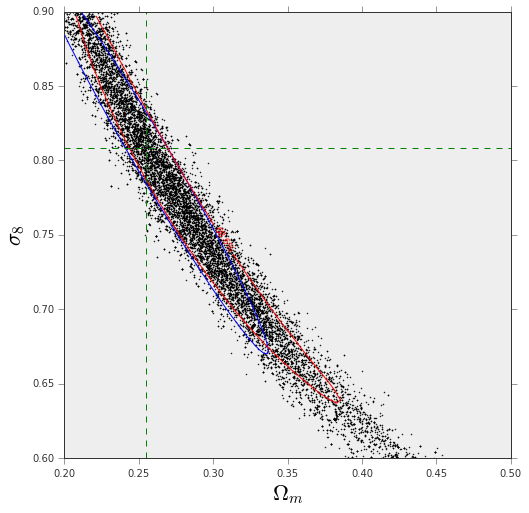

In [12]:
#Plot setup
fig,ax = plt.subplots(figsize=(8,8))

#Likelihood map
contour = ContourPlot.from_scores(scores,parameters=["Om","sigma8"],feature_names=["likelihood"],plot_labels=[r"$\Omega_m$",r"$\sigma_8$"],fig=fig,ax=ax)
p_value = 0.684
contour.getLikelihoodValues([p_value],precision=0.01)
contour.plotContours(colors=["red"])
contour.labels()

#Fisher confidence ellipse
ellipse = fisher.confidence_ellipse(covariance,correct=1000,observed_feature=test_data,parameters=["Om","sigma8"],p_value=p_value,fill=False,edgecolor="blue")
ax.add_artist(ellipse)

#MCMC samples
ax.scatter(samples["Om"],samples["sigma8"],marker=".",color="black",s=1)
ax.set_xlim(0.2,0.5)
ax.set_ylim(0.6,0.9)